In [ ]:
!pip install tensorflow==2.3.1
!pip install tensorflow_quantum==0.4.0
!pip install cirq
!pip install quple==0.7.0

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import cirq
import quple
from quple.utils.utils import plot_roc_curve

## Task 2 - MNIST Classification using Quantum Machine Learning

The objective of this task is to use existing quantum machine learning techniques to classify images from the MNIST dataset. Since the problem belongs to the domain of computer vision, the problem can be tackled by using quantum convolutional neural networks.

* A classical CNN consists of a sequence of image processing layers. Each layer is made up of a **convolution layer** and a **pooling layer**. The main purpose of a convolution layer is to extract features (to form a feature map) from the input image through the application of filters (usually with a size of $3 \times 3$) that scans the image pixels, while a pooling layer downsamples the resulting feature map from the convolution layer by summarising its features. Once the feature map size becomes sufficiently small after repeated appliation of convolution and pooling, the resultant image is passed to a fully-connected layer to compute the final output for classification.

* In order to implement a quantum version of CNN, we first need a way to encode classical image into the quantum state of a quantum circuit. [Farhi et al.]((https://arxiv.org/pdf/1802.06002.pdf)) propose representing each pixel with a qubit, with the state depending on the value of the pixel. Therefore, for an image of dimension $w \times h$, a quantum circuit with a grid qubit layout of the same shape can be used to encode the image. To represent the convolutional and pooling layers, we can use the implementation from [Cong et al.](https://arxiv.org/pdf/1810.03787.pdf) which uses parameterised quantum circuits (PQCs) constructed with a particular set of gate operations for each layer. The values of the parameters in the PQCs therefore represents the weights in the corresponding classical neural network layers. We will discuss how the layers are constructed in the later part of this task.



### 1. Loading the dataset and some preprocessing

* The dataset consists of 60,000 training examples and 10,000 testing examples.
* Each sample is a $28 \times 28 \times 1$ image with 1 colour channel.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
print('Dimension of training sample: {}'.format(x_train.shape))
print('Dimension of test sample: {}'.format(x_test.shape))

Number of original training examples: 60000
Number of original test examples: 10000
Dimension of training sample: (60000, 28, 28, 1)
Dimension of test sample: (10000, 28, 28, 1)


In [4]:
# Convert the problem to a binary classification problem
# Let's retain labels corresponding to 0 and 1 only. 0 -> False, 1 -> True

def filter_01(x, y):
  retain = (y == 0) | (y == 1)
  x, y = x[retain], y[retain]
  y = y == 1
  return x, y

In [5]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12665
Number of filtered test examples: 2115


Each sample has $28 \times 28 (=784)$ datapoints. If we are to encode each pixel data into one qubit just like the ordinary way, this would require 1024 qubits which is way beyond the capability of simulators (and of course the currently NISQ computer hardware).

Therefore, we need to make some smart decisions to trim down and compress the image into a more useful representation that can fit the size of an ordinary quantum simulator circuit (which should be less than 20). 

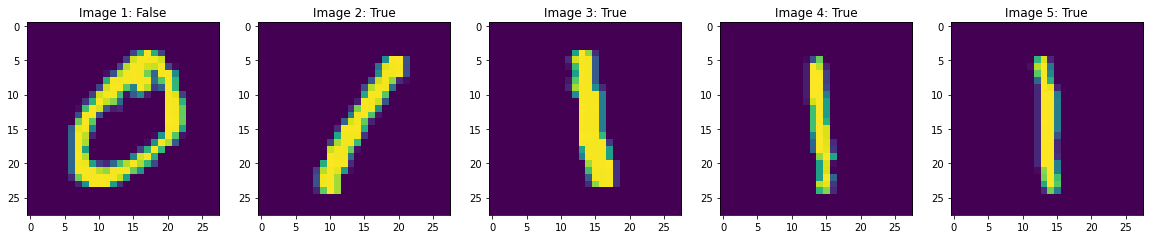

In [6]:
# Look at some image samples

fig = plt.figure(figsize=(20,40))
columns = 5
rows = 1
plt.subplots_adjust(hspace=0.3)
for i in range(x_train[:rows*columns].shape[0]):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title('Image {}: {}'.format(i+1, y_train[i]))
    plt.imshow(np.squeeze(x_train[i]))

An image size of $28 \times 28$ is too huge to feed to a quantum neural net. We need to downscale these images to a managable size. We use TensorFlow's image resize method to resize the image to a $4 \times 4$ image which is much more tractable

In [7]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

In [8]:
x_train_small = np.squeeze(x_train_small)
x_test_small = np.squeeze(x_test_small)

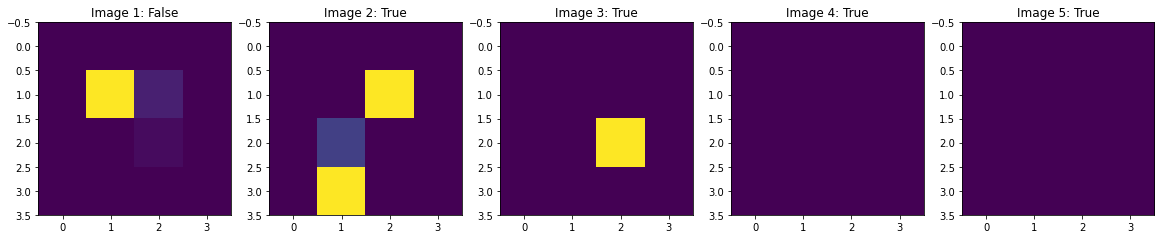

In [9]:
# Look at some more (downscaled) image samples

fig = plt.figure(figsize=(20,40))
columns = 5
rows = 1
plt.subplots_adjust(hspace=0.3)
for i in range(x_train_small[:rows*columns].shape[0]):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title('Image {}: {}'.format(i+1, y_train[i]))
    plt.imshow(np.squeeze(x_train_small[i]))

### 2. Creating the QCNN

For the model, we use
* **Mean Squared Eroor** as the loss function;
* **Adam** as the optimizer for the parameters in the variational quantum circuit layers to minimize the loss function.
* **Accuracy** as the metric
* A `random_state` option is also incuded to introduce reproducability.

In [10]:
from typing import Optional, Union

class QCNN(tf.keras.Sequential):  
    def __init__(self, encoding_circuit:'cirq.Circuit', variational_circuit:'cirq.Circuit', 
                 lr=1e-4,
                 differentiator:Optional[tfq.differentiators.Differentiator]=None,
                 regularizer=None,
                 repetitions=None,
                 loss='mse', 
                 metrics=['auc', 'acc'],                 
                 readout=None,
                 random_state:int=2,                 
                 name:str='QCNN', *arg, **args):
        
        """ Creates a Quantum Convolutional Network
        
        Args:
            encoding_circuit: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit used for data encoding.
            variational_circuit: cirq.Circuit or quple.QuantumCircuit instace
                A parameterised quantum circuit which the parameters
                are to be tuned by a classical optimizer.
            optimizer: string (name of optimizer)or tf.keras.optimizers.Optimizer instance; default='adam'
                The optimizer to use for tuning the parameters in the
                variational circuit. 
            differentiator: Optional `tfq.differentiator` object 
                To specify how gradients of variational circuit should be calculated.
            regularizer: Optional `tf.keras.regularizer` object
                Regularizer applied to the parameters of the variational circuit.
            repetitions: int; default=None
                Number of repetitions for measurement
            loss: string (name of objective function), objective function or tf.keras.losses.Loss instance
                An objective function of the form f_n(y_true,y_pred) which maps truth labels and the predicted
                labels to some loss values. 
            activation: string (name of activation function) or activation function instance
                The activation function for the output layer.
            metrics: List of string (name of a built-in function), function or a tf.keras.metrics.Metric instance. 
                List of metrics to be evaluated by the model during training and testing. 
            readout: `cirq.PauliSum` or Python `list` of `cirq.PauliSum` objects
                Measurement operators (observables) for the variational circuit layer.
            trainable_dense_layer: boolean; default=False
                Whether to train the weights in the the classical output layer.
            random_state: Optional int
                The random state for reproducible result.
            name: Optional str, default='QCNN'
                Name given to the classifier.
        """
        super(QCNN, self).__init__()
        self.readout = readout
        self.encoding_circuit = encoding_circuit
        self.variational_circuit = variational_circuit
        self.differentiator = differentiator        
        self.regularizer = regularizer
        self.repetitions = repetitions    
        self.random_state = random_state
        self.set_random_state(self.random_state)
        layers = self._get_vqc_layers()
        super(QCNN, self).__init__(layers, name)
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        
        self.auc_metric = tf.keras.metrics.AUC()
        metrics_ = []
        for metric in metrics:
            if metric.lower() == 'auc':
                metrics_.append(self.custom_auc)
            else:
                metrics_.append(metric)
        self.compile(loss=loss, optimizer=optimizer, metrics=metrics_)
        
    @staticmethod
    def set_random_state(random_state=None):
        tf.random.set_seed(random_state)
        np.random.seed(random_state)       
        
    def _get_vqc_layers(self):
       # PQC layer needs an input in string format
        input_layer = tf.keras.layers.Input(shape=(), dtype=tf.string)
        
        if not self.readout:
            # If readout is not provided, perform a Pauli Z on the first qubit
            qubits = quple.get_circuit_qubits(self.variational_circuit)
            readout = [cirq.Z(qubits[0])]
        else:
            readout = self.readout    
        pqc_layer = tfq.layers.PQC(self.variational_circuit,
                                   readout,
                                   repetitions=self.repetitions,
                                   differentiator=self.differentiator,
                                   regularizer=self.regularizer)
        return [input_layer, pqc_layer]  
                
    def convert_to_tensor(self, x:np.ndarray):
        return tfq.convert_to_tensor(self.encoding_circuit.resolve_parameters(x))                    

    def compile(self, optimizer='adam', loss='binary_crossentropy', 
                metrics=['binary_accuracy'], *args, **kwargs):
        super(QCNN, self).compile(optimizer, loss, metrics, *args, **kwargs)

    @tf.function
    def custom_auc(self, y_true, y_pred):
        y_pred_ = (y_pred+1)/2
        return self.auc_metric(y_true, y_pred_)
    
    def train(self, x_train, y_train, x_val=None, y_val=None, 
              batch_size:Optional[int]=None,
              epochs:int=100, 
              weights=None,
              *args, **kwargs):

        if weights is None:
            weights = (None, None, None)
            
        if (x_val is None) and (y_val is None):
            validation_data = None
        else:
            validation_data = (x_val, y_val) if weights is None else (x_val, y_val, weights[1])
 
        self.fit(x_train, y_train, batch_size, epochs,
                 validation_data=validation_data,
                 sample_weight=weights[0])

    def fit(self, x, y,
            batch_size:Optional[int]=None,
            epochs:int=1, 
            validation_data=None,
            *args, **kwargs):
        
        if isinstance(x, np.ndarray):
            x = self.convert_to_tensor(x)
            
        if validation_data and isinstance(validation_data, tuple):
            self._attributes['val_size'] = len(validation_data[0])
            if isinstance(validation_data[0], np.ndarray):
                x_val = self.convert_to_tensor(validation_data[0])
                validation_data = (x_val, *validation_data[1:])
                
        return super(QCNN, self).fit(x, y,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    validation_data=validation_data,
                                    *args, **kwargs)
    
    def evaluate(self, x, y, *args, **kwargs):
        if isinstance(x, np.ndarray):
            x = self.convert_to_tensor(x)
        return super(QCNN, self).evaluate(x, y, *args, **kwargs)
    
    def predict(self, x, *args, **kwargs):
        if isinstance(x, np.ndarray):
            x = self.convert_to_tensor(x)
        return super(QCNN, self).predict(x, *args, **kwargs)    
    
    def test(self, x, y, plot=True):
        score = self.predict(x)
        fpr, tpr, thresholds = roc_curve(y, score)
        roc_auc = auc(fpr, tpr)
        if plot:
            return plot_roc_curve(fpr, tpr, 'QDCGAN')
        else:
            return roc_auc    

### 3. Encoding the data in quantum circuits

We implement the encoding circuits used by in https://arxiv.org/abs/1804.11326. 

Essentially, the encoding circuit consist of a layer of single-qubit `RZ` rotation which encodes each pixel value of the input image as the rotation angle on the corresponding qubit along the $Z$-axis. It is then followed by a layer of two-qubit `RZZ` rotation which which encode the $i$-th pixel and $j$-th pixel values as the rotation along the $Z_{i}\otimes Z_{j}$-axis of the $i$-th and $j$-th qubit via some encoding function $\theta_{i,j}(x_i, x_k)$. Here the encoding function used is $\theta_{i,j} = [((x_i + x_k)/2]^3$.

In [11]:
from quple.data_encoding import EncodingCircuit
from quple import PauliBlock
from quple.data_encoding.encoding_maps import polynomial

# define a grid qubit layout matching the input dimensions, that is, 4 x 4

qubits = cirq.GridQubit.rect(4, 4)
encoding_circuit = EncodingCircuit(qubits, copies=2, rotation_blocks=['H', 'RZ'],
                                   entanglement_blocks=[PauliBlock('ZZ', polynomial(degree=3))],
                                   entangle_strategy='linear')

In [12]:
encoding_circuit

(0, 0): ───H───Rz(pi*<x_0/pi>)────@────────────────────────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*<x_0/pi>)────@───────────────────────────────────────────────────@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                  │                                    │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               │                                                   │
(0, 1): ───H───Rz(pi*<x_1/pi>)────X───Rz(pi*<(x_0/2 + x_1/2)**3/pi>)───X───@────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Rz(pi*<x_1/pi>)────X──────────────────Rz(pi*<(x_0/2 + x_1/2)**3/pi>)───X───@────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                           │                                    │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### 4. Constructing the convolutional blocks

In [13]:
from quple import ParameterisedCircuit, ParameterisedBlock

def ConvLayer(qubits):
  conv_block = ParameterisedBlock(copies=1, rotation_blocks=['RZ', 'RY', 'RX'], entanglement_blocks=['ZZ', 'YY', 'XX'])
  conv_layer = ParameterisedCircuit(qubits, copies=1, rotation_blocks=[], entanglement_blocks=[conv_block], entangle_strategy='filter_mesh')
  return conv_layer

def PoolLayer(qubits):
    pool_block = ParameterisedBlock(copies=1, rotation_blocks=['RZ','RY','RX'], entanglement_blocks=['CX'])
    pool_layer = ParameterisedCircuit(qubits, copies=1, rotation_blocks=[], entanglement_blocks=[pool_block], entangle_strategy='pool_mesh')
    return pool_layer

The **convolutional layer** is made up of circuit blocks that serve as **filters** to the input data. Each filter works on two qubits (so a (1x2) filter). The filter first rotate each qubit with `RZ`, `RY` and `RX` gates by a parameterised angle which served as weights to the filter. Then a sequence of three parameterised two-qubit gates `ZZ`, `YY` and `XX` gates are applied which entangles the two corresponding qubits and extract feature information from them. 

In principle, any sets of parameterised single qubit and two qubit gates should work.

The **pooling layer** is made up of circuit blocks that for **down sampling of the convolution feature map**. Each circuit block acts on two qubits which their information are to be combined. Each blocks start with single qubit rotations of `RZ`, `RY` and `RX` gates with a parameterised angle which served as weights to control the down sampling. Then a `CNOT` gate is applied to the two qubits of interest. One of the qubit will serve as the source and the other as the target. Depending on the state of the source qubit, there will be a bit flip on the target qubit. This essentially creates a down sampling effect to carry the information from the source qubit to the target qubit.

In [14]:
qubits_layer1 = cirq.GridQubit.rect(4, 4)
variational_circuit = ParameterisedCircuit(qubits_layer1)
variational_circuit.merge(ConvLayer(qubits_layer1))
variational_circuit.merge(PoolLayer(qubits_layer1))

# Now we have an effective 2x2 image
# Apply the convolution and pooling again to reduce it to 1x1

qubits_layer2 = [qubit for i,qubit in enumerate(qubits_layer1) if i%4 ==0]
variational_circuit.merge(ConvLayer(qubits_layer2))
variational_circuit.merge(PoolLayer(qubits_layer2))
variational_circuit

(0, 0): ───Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───ZZ─────────YY─────────XX──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(θ_0)───Ry(θ_2)───Rx(θ_4)───ZZ─────────YY─────────XX──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(θ_9)────Ry(θ_11)───Rx(θ_13)───@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(θ_9)────Ry(θ_11)───Rx(θ_13)───@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────Rz(θ_15)───Ry(θ_17)───Rx(θ_19)───ZZ──────────YY──────────XX───────────────────────────────────────────────────────────────────────────────Rz(θ_15)───Ry(θ_17)───Rx(θ_19)───ZZ──────────YY──────────XX───────────────────────────────────────────────────────────────────────────────Rz(θ_24)───Ry(θ_26)───Rx(θ_28)───@────────────────────────────────────────Rz(θ_24)───Ry(θ_26)───Rx(θ_28)───@────────────────────────────────────────
                                         │          │          │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             │          │          │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### 5. Training the Model

In [15]:
qcnn = QCNN(encoding_circuit=encoding_circuit, variational_circuit=variational_circuit, lr=5e-3, loss='mse')

In [16]:
x_train_small = np.reshape(x_train_small, (x_train_small.shape[0], 16))
x_test_small = np.reshape(x_test_small, (x_test_small.shape[0], 16))

In [17]:
# train on just 300 samples as an example
qcnn.train(x_train_small[:300], y_train[:300], batch_size=30, epochs=30)

Epoch 1/30
10/10 [==============================] - 50s 5s/step - loss: 0.4107 - custom_auc: 0.4718 - acc: 0.4500 - auc: 0.5534
Epoch 2/30
10/10 [==============================] - 51s 5s/step - loss: 0.2602 - custom_auc: 0.7322 - acc: 0.5067 - auc: 0.6501
Epoch 3/30
10/10 [==============================] - 50s 5s/step - loss: 0.2072 - custom_auc: 0.7889 - acc: 0.7333 - auc: 0.8001
Epoch 4/30
10/10 [==============================] - 50s 5s/step - loss: 0.1979 - custom_auc: 0.7690 - acc: 0.7467 - auc: 0.8335
Epoch 5/30
10/10 [==============================] - 50s 5s/step - loss: 0.1891 - custom_auc: 0.8411 - acc: 0.7833 - auc: 0.8618
Epoch 6/30
10/10 [==============================] - 49s 5s/step - loss: 0.1820 - custom_auc: 0.8974 - acc: 0.7633 - auc: 0.8817
Epoch 7/30
10/10 [==============================] - 50s 5s/step - loss: 0.1767 - custom_auc: 0.8855 - acc: 0.7900 - auc: 0.8838
Epoch 8/30
10/10 [==============================] - 50s 5s/step - loss: 0.1711 - custom_auc: 0.9081 - ac

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

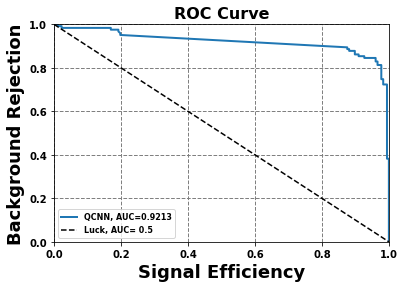

In [22]:
y_pred = qcnn.predict(x_test_small[:300])
fpr, tpr, thresholds = roc_curve(y_test[:300], y_pred)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, 'QCNN')

We observe that the network is able to predict labels with a pretty good accuracy. Of course, the results are not as good as its classical counterpart, but that is because quantum networks are hard to deal with due to their small size, and the smaller number of variational parameters they have. We can add a few more layers to try and improve the accuracy of the network but that is not guarunteed to work.